# Multinomial Naive Bayes Classifier

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
from random import sample

text = load_dataset("Hello-SimpleAI/HC3", "all", trust_remote_code=True)
print(text)
train_dataset= text['train']

0000.parquet:   0%|          | 0.00/39.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})


In [3]:
import pandas as pd
df = pd.DataFrame(train_dataset)
print(df.head())

  id                                           question  \
0  0  Why is every book I hear about a " NY Times # ...   
1  1  If salt is so bad for cars , why do we use it ...   
2  2  Why do we still have SD TV channels when HD lo...   
3  3  Why has nobody assassinated Kim Jong - un He i...   
4  4  How was airplane technology able to advance so...   

                                       human_answers  \
0  [Basically there are many categories of " Best...   
1  [salt is good for not dying in car crashes and...   
2  [The way it works is that old TV stations got ...   
3  [You ca n't just go around assassinating the l...   
4  [Wanting to kill the shit out of Germans drive...   

                                     chatgpt_answers       source  
0  [There are many different best seller lists th...  reddit_eli5  
1  [Salt is used on roads to help melt ice and sn...  reddit_eli5  
2  [There are a few reasons why we still have SD ...  reddit_eli5  
3  [It is generally not acceptable o

In [4]:
import string
import re
from nltk.corpus import stopwords
def preprocess_text(text):
  stop_words = set(stopwords.words('english'))
  text = text.lower() #make everything lower case
  text = text.replace('\n','') #remove \n characters
  text = re.sub(r'[^\w\s]', ' ', text) #remove punctuation and special characters
  text = ' '.join([word for word in text.split(" ") if word.isalpha()]) #remove all numbers
  text = ' '.join([word for word in  text.split(" ") if word not in stop_words]) #remove all stopwords (see imports to help you with this)

  return text
    
df['chatgpt_answers'] = df['chatgpt_answers'].astype(str).apply(preprocess_text)
df['human_answers'] = df['human_answers'].astype(str).apply(preprocess_text)

In [5]:
print(df['chatgpt_answers'][0])

many different best seller lists published various organizations new york times one new york times best seller list weekly list ranks best selling books united states based sales data number different retailers list published new york times newspaper widely considered one influential best seller lists book industry nit important note new york times best seller list best seller list many lists rank top selling books different categories different countries possible book could best seller one list another nadditionally term best seller often used broadly refer book selling well regardless whether specific best seller list possible may hear book best seller even specifically ranked number one best seller new york times list list


In [6]:
# Convert all answers to strings (handle lists and NaN)
human_data = pd.DataFrame({
    'text': df['human_answers'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)),
    'label': 0
})

chatgpt_data = pd.DataFrame({
    'text': df['chatgpt_answers'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)),
    'label': 1
})

# Combine datasets and shuffle
combined_df = pd.concat([human_data, chatgpt_data], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

combined_df.head()


,text,label
0,giant phonebook provides information anything ...,0
1,pi denoted symbol π mathematical constant repr...,1
2,jumpup decent explanations misses quite bit nu...,0
3,berkshire hathaway large diversified conglomer...,1
4,voyager satellites several features help survi...,1


Class Distribution:
label
0    24322
1    24322
Name: count, dtype: int64
The data is relatively balanced.


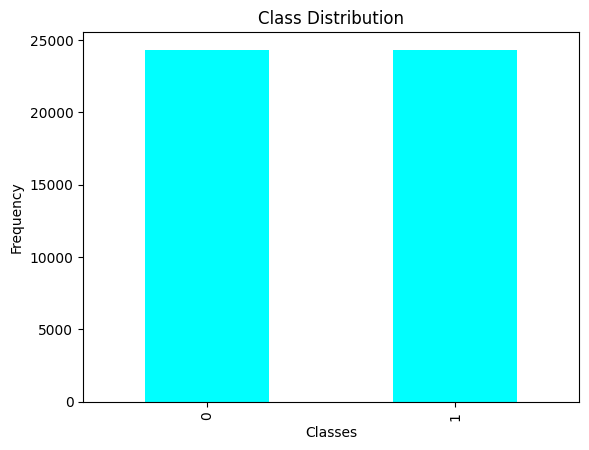

In [7]:
import matplotlib.pyplot as plt

class_distribution = combined_df['label'].value_counts()
print("Class Distribution:")
print(class_distribution)

max_class = class_distribution.max()
min_class = class_distribution.min()

if max_class / min_class <= 1: 
    print("The data is relatively balanced.")
else:
    print("The data is imbalanced.")

class_distribution.plot(kind='bar', color='cyan')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X = combined_df['text']
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=39)

# X_train, y_train -> Training set
# X_val, y_val     -> Validation set
# X_test, y_test   -> Test set

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# Vectorize the text
vectorizer = TfidfVectorizer(ngram_range=(2, 5), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB(alpha=1)
nb_classifier.fit(X_train_vec, y_train)

# Evaluate the model on the validation set
y_val_pred = nb_classifier.predict(X_val_vec)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate the model on the test set
y_test_pred = nb_classifier.predict(X_test_vec)
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))



Validation Accuracy: 0.8087162092712509

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.63      0.77      4846
           1       0.73      0.99      0.84      4883

    accuracy                           0.81      9729
   macro avg       0.86      0.81      0.80      9729
weighted avg       0.85      0.81      0.80      9729


Test Accuracy: 0.8046047898036797

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76      4886
           1       0.72      0.99      0.83      4843

    accuracy                           0.80      9729
   macro avg       0.85      0.81      0.80      9729
weighted avg       0.85      0.80      0.80      9729



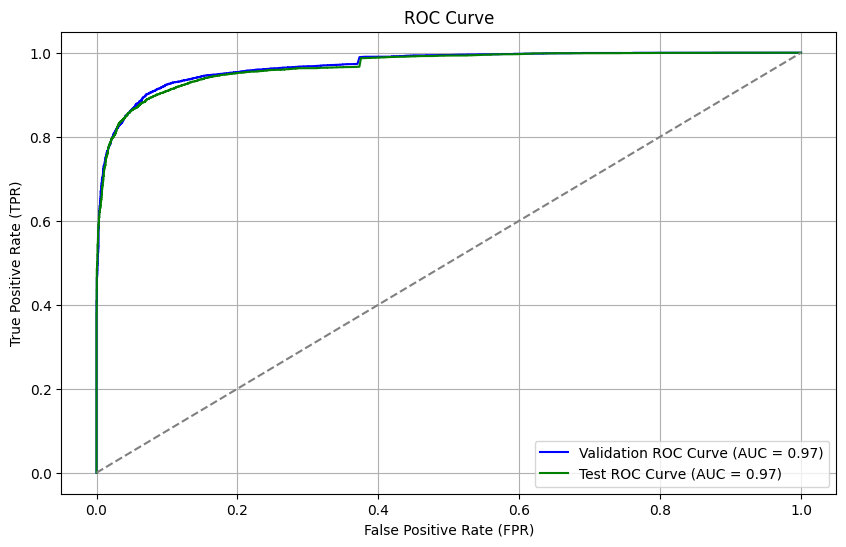

In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get the predicted probabilities for the positive class
y_val_proba = nb_classifier.predict_proba(X_val_vec)[:, 1]
y_test_proba = nb_classifier.predict_proba(X_test_vec)[:, 1]

# Compute the ROC curve for the validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)
roc_auc_val = auc(fpr_val, tpr_val)

# Compute the ROC curve for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_val, tpr_val, color='blue', label=f"Validation ROC Curve (AUC = {roc_auc_val:.2f})")
plt.plot(fpr_test, tpr_test, color='green', label=f"Test ROC Curve (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing

plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# XGBoost

In [15]:
from xgboost import XGBClassifier

# Initialize and train the XGBoost classifier
xgb_classifier = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    tree_method='gpu_hist',
    n_estimators=100,
    max_depth=6,
    num_class=2
)

xgb_classifier.fit(
    X_train_vec, 
    y_train, 
    eval_set=[(X_val_vec, y_val)], 
    early_stopping_rounds=100, 
    verbose=True
)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:52:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.70343
[1]	validation_0-mlogloss:0.72345
[2]	validation_0-mlogloss:0.74460
[3]	validation_0-mlogloss:0.76353
[4]	validation_0-mlogloss:0.77914
[5]	validation_0-mlogloss:0.79138
[6]	validation_0-mlogloss:0.80066
[7]	validation_0-mlogloss:0.80753
[8]	validation_0-mlogloss:0.81254
[9]	validation_0-mlogloss:0.81614


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [17]:
# Predict on the test set
y_test_pred = xgb_classifier.predict(X_test_vec)
y_test_proba = xgb_classifier.predict_proba(X_test_vec)[:, 1]  # Probabilities for ROC

# Metrics
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Accuracy: 0.5598725459965053

Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69      4886
           1       0.97      0.12      0.21      4843

    accuracy                           0.56      9729
   macro avg       0.75      0.56      0.45      9729
weighted avg       0.75      0.56      0.46      9729



# BERT

In [18]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch

# Convert the dataframe to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(combined_df)

# Split into train and test sets
split_data = hf_dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% temp
train_data = split_data['train']
temp_data = split_data['test']

# Further split temp_data into validation and test sets
split_temp = temp_data.train_test_split(test_size=0.5, seed=42)  # 50% val, 50% test from temp_data
val_data = split_temp['train']
test_data = split_temp['test']

# Print sizes to confirm splits
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Use the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize(batch):
    encoding = tokenizer(batch['text'], padding=True, truncation=True, max_length=256)
    encoding['label'] = batch['label']
    return encoding

# Tokenize each split separately
train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

# Convert to PyTorch-friendly format
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


# Create DataLoaders
def format_dataset(data):
    return torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

train_loader = format_dataset(train_data)
val_loader = format_dataset(val_data)
test_loader = format_dataset(test_data)

# Confirm DataLoader creation
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Train size: 38915, Validation size: 4864, Test size: 4865


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/38915 [00:00<?, ? examples/s]

Map:   0%|          | 0/4864 [00:00<?, ? examples/s]

Map:   0%|          | 0/4865 [00:00<?, ? examples/s]

Train DataLoader: 609 batches
Validation DataLoader: 76 batches
Test DataLoader: 77 batches


In [33]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


training_args = TrainingArguments(
    output_dir="./results",                    
    eval_strategy="epoch",                     
    save_strategy="epoch",                     
    learning_rate=2e-5,                        
    per_device_train_batch_size=64,            
    per_device_eval_batch_size=64,             
    num_train_epochs=3,                        
    weight_decay=0.01,                         
    logging_dir="./logs",                      
    logging_steps=10,                          
    load_best_model_at_end=True,               
    metric_for_best_model="accuracy",          
    report_to="none",                          
    seed=42,
    fp16=True
)

from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Match your variables
trainer = Trainer(
    model=model,                               
    args=training_args,                        
    train_dataset=train_data,                  
    eval_dataset=val_data,                     
    tokenizer=tokenizer,                       
    compute_metrics=compute_metrics            
)


trainer.train()


print("Evaluating on the test set...")
results = trainer.evaluate(test_data)  
print(f"Test Results: {results}")


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Using device: cuda
 
Training Progress: 100%|██████████| 3/3 [13:56<00:00,  2.82it/s]
Evaluating on the test set...
Test Results: {'eval_loss': 0.0648968368768692, 'eval_accuracy': 0.9449003083247687, 'eval_runtime': 45.3361, 'eval_samples_per_second': 137.678, 'eval_steps_per_second': 2.179, 'epoch': 3.0}



In [75]:
from sklearn.metrics import classification_report
import pandas as pd

# Custom function to suppress 'support' in the report
def generate_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    # Convert the report to a DataFrame to suppress 'support'
    report_df = pd.DataFrame(report).T.drop(columns=["support"])
    return report_df

# Evaluation function
def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Evaluate on validation and test sets
val_preds, val_labels = evaluate(val_loader)
test_preds, test_labels = evaluate(test_loader)

# Generate and display reports without 'support'
val_report = generate_classification_report(val_labels, val_preds)
test_report = generate_classification_report(test_labels, test_preds)

print("\nValidation Classification Report:\n", val_report)
print("\nTest Classification Report:\n", test_report)


Validation Classification Report:
               precision    recall  f1-score

           0       0.95      0.98      0.96        
           1       0.90      0.85      0.87        

    accuracy                           0.94       
   macro avg       0.92      0.91      0.92       
weighted avg       0.92      0.94      0.93       


Test Classification Report:
               precision    recall  f1-score   

           0       0.93      0.97      0.95        
           1       0.88      0.82      0.85        

    accuracy                           0.94       
   macro avg       0.90      0.89      0.90       
weighted avg       0.90      0.92      0.91       


# DistilBert

In [76]:

from datasets import load_dataset
from random import sample

text = load_dataset("Hello-SimpleAI/HC3", "all", trust_remote_code=True)
print(text)
train_dataset= text['train']

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})


In [77]:
import pandas as pd
df = pd.DataFrame(train_dataset)
print(df.head())

  id                                           question  \
0  0  Why is every book I hear about a " NY Times # ...   
1  1  If salt is so bad for cars , why do we use it ...   
2  2  Why do we still have SD TV channels when HD lo...   
3  3  Why has nobody assassinated Kim Jong - un He i...   
4  4  How was airplane technology able to advance so...   

                                       human_answers  \
0  [Basically there are many categories of " Best...   
1  [salt is good for not dying in car crashes and...   
2  [The way it works is that old TV stations got ...   
3  [You ca n't just go around assassinating the l...   
4  [Wanting to kill the shit out of Germans drive...   

                                     chatgpt_answers       source  
0  [There are many different best seller lists th...  reddit_eli5  
1  [Salt is used on roads to help melt ice and sn...  reddit_eli5  
2  [There are a few reasons why we still have SD ...  reddit_eli5  
3  [It is generally not acceptable o

In [78]:
import string
import re
from nltk.corpus import stopwords
def preprocess_text(text):
  text = text.lower() #make everything lower case
  text = text.replace('\\n','') #remove \n characters
  text = text.replace('\\','')
    
  return text
    
df['chatgpt_answers'] = df['chatgpt_answers'].astype(str).apply(preprocess_text)
df['human_answers'] = df['human_answers'].astype(str).apply(preprocess_text)

In [79]:
print(df['chatgpt_answers'][0])

['there are many different best seller lists that are published by various organizations, and the new york times is just one of them. the new york times best seller list is a weekly list that ranks the best-selling books in the united states based on sales data from a number of different retailers. the list is published in the new york times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. it's important to note that the new york times best seller list is not the only best seller list out there, and there are many other lists that rank the top-selling books in different categories or in different countries. so it's possible that a book could be a best seller on one list but not on another. additionally, the term "best seller" is often used more broadly to refer to any book that is selling well, regardless of whether it is on a specific best seller list or not. so it's possible that you may hear about a book being a "best selle

In [80]:
# Convert all answers to strings (handle lists and NaN)
human_data = pd.DataFrame({
    'text': df['human_answers'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)),
    'label': 0
})

chatgpt_data = pd.DataFrame({
    'text': df['chatgpt_answers'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)),
    'label': 1
})

# Combine datasets and shuffle
combined_df = pd.concat([human_data, chatgpt_data], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

combined_df.head()


,text,label
0,['its a giant phonebook that provides informat...,0
1,"['pi, denoted by the symbol ""π,"" is a mathemat...",1
2,['jumpup has decent explanations but misses qu...,0
3,"[""berkshire hathaway is a large, diversified c...",1
4,['the voyager satellites have several features...,1


In [81]:
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch

# Convert the dataframe to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(combined_df)

# Split into train and test sets
split_data = hf_dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% temp
train_data = split_data['train']
temp_data = split_data['test']

# Further split temp_data into validation and test sets
split_temp = temp_data.train_test_split(test_size=0.5, seed=42)  # 50% val, 50% test from temp_data
val_data = split_temp['train']
test_data = split_temp['test']

# Print sizes to confirm splits
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Use the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def tokenize(batch):
    encoding = tokenizer(batch['text'], padding=True, truncation=True, max_length=256)
    encoding['label'] = batch['label'] 
    return encoding

# Tokenize each split separately
train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

# Convert to PyTorch-friendly format
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


# Create DataLoaders
def format_dataset(data):
    return torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

train_loader = format_dataset(train_data)
val_loader = format_dataset(val_data)
test_loader = format_dataset(test_data)

# Confirm DataLoader creation
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")


Train size: 38915, Validation size: 4864, Test size: 4865


Map:   0%|          | 0/38915 [00:00<?, ? examples/s]

Map:   0%|          | 0/4864 [00:00<?, ? examples/s]

Map:   0%|          | 0/4865 [00:00<?, ? examples/s]

Train DataLoader: 609 batches
Validation DataLoader: 76 batches
Test DataLoader: 77 batches


In [83]:
import torch
from transformers import Trainer, TrainingArguments
from transformers import DistilBertForSequenceClassification

# Load BERT with a classification head
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define training arguments with GPU settings
training_args = TrainingArguments(
    output_dir="./results",          # Directory to save results
    evaluation_strategy="epoch",    # Evaluate model every epoch
    save_strategy="epoch",          # Save the model every epoch
    learning_rate=5e-5,             # Learning rate
    per_device_train_batch_size=64, # Batch size for training
    per_device_eval_batch_size=64,  # Batch size for evaluation
    num_train_epochs=3,             # Number of training epochs
    weight_decay=0.01,              # Weight decay for optimizer
    logging_dir="./logs",           # Directory to save logs
    logging_steps=10,               # Log every 10 steps
    save_total_limit=2,             # Limit the number of saved checkpoints
    load_best_model_at_end=True,    # Load the best model at the end of training
    greater_is_better=True,         # Higher accuracy is better
    seed=42,                        # Ensure reproducibility
    fp16=True,
    report_to="none",  
)




# Create Trainer instance
trainer = Trainer(
    model=model,                        # Pretrained model with classification head
    args=training_args,                 # Training arguments
    train_dataset=train_data,           # Training dataset
    eval_dataset=val_data,              # Validation dataset
    tokenizer=tokenizer,                # Tokenizer  # Metrics function
)

# Train the model on GPU
trainer.train()



# Save the model
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")


Using device: cuda
Training Progress: 100%|██████████| 3/3 [07:56<00:00,  2.69it/s]

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json')



In [84]:
from sklearn.metrics import classification_report

# Evaluation function
def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            # Ensure keys are correctly accessed
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)  # 'labels' key must match DataLoader's format
            
            # Model forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            # Predictions and labels
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Ensure function returns predictions and labels
    return all_preds, all_labels


# Evaluate on validation and test sets
val_preds, val_labels = evaluate(val_loader)
test_preds, test_labels = evaluate(test_loader)

print("\nValidation Classification Report:\n", classification_report(val_labels, val_preds))
print("\nTest Classification Report:\n", classification_report(test_labels, test_preds))



Validation Classification Report:
               precision    recall  f1-score   

           0       0.92      0.95      0.93        
           1       0.91      0.90      0.90        

    accuracy                           0.92       
   macro avg       0.91      0.92      0.92       
weighted avg       0.92      0.93      0.92       


Test Classification Report:
               precision    recall  f1-score   

           0       0.91      0.94      0.92        
           1       0.90      0.88      0.89        

    accuracy                           0.92       
   macro avg       0.90      0.91      0.91       
weighted avg       0.91      0.93      0.91       
